In [40]:
%matplotlib inline
from matplotlib import style
style.use('fivethirtyeight')
import matplotlib.pyplot as plt

In [41]:
import numpy as np
import pandas as pd
import datetime as dt


# Reflect Tables into SQLAlchemy ORM

In [42]:
# Python SQL toolkit and Object Relational Mapper
import sqlalchemy
from sqlalchemy.ext.automap import automap_base
from sqlalchemy.orm import Session
from sqlalchemy import create_engine, func, inspect

In [43]:
# create engine to hawaii.sqlite
engine = create_engine("sqlite:///../Resources/hawaii.sqlite")

In [44]:
# reflect an existing database into a new model
Base = automap_base()
# reflect the tables
Base.prepare(autoload_with=engine)

In [45]:
# View all of the classes that automap found
Base.classes.keys()

['measurement', 'station']

In [46]:
# Save references to each table
Measurement = Base.classes.measurement
Station = Base.classes.station

In [47]:
# Create our session (link) from Python to the DB
session = Session(bind=engine)

In [48]:
inspector = inspect(engine)

In [49]:
columns = inspector.get_columns('Measurement')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
date TEXT
prcp FLOAT
tobs FLOAT


In [50]:
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


# Exploratory Precipitation Analysis

In [51]:
# Find the most recent date in the data set.
most_recent = session.query(Measurement.date).order_by(Measurement.date.desc()).first()
most_recent

('2017-08-23',)

2016-08-23 00:00:00
2009-01-01 00:00:00


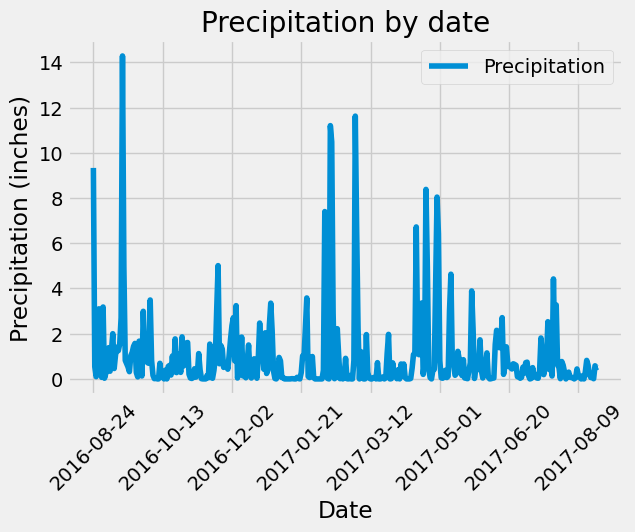

In [52]:
# Design a query to retrieve the last 12 months of precipitation data and plot the results. 
# Starting from the most recent data point in the database. 
date = dt.datetime.strptime(most_recent[0], '%Y-%m-%d')
year_prior = date - dt.timedelta(days=365)
print(year_prior)
# Calculate the date one year from the last date in data set.
last_date = session.query(Measurement.date).order_by(Measurement.date.asc()).first()
date = dt.datetime.strptime(last_date[0], '%Y-%m-%d')
year_from_last = date - dt.timedelta(days = 365)
print(year_from_last)


# Perform a query to retrieve the data and precipitation scores
sel = [Measurement.date, func.sum(Measurement.prcp)]
year_precipitation = session.query(*sel).\
    filter(func.strftime(Measurement.date) >= year_prior).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()
year_precipitation

# Save the query results as a Pandas DataFrame. Explicitly set the column names
year_precipitation_df = pd.DataFrame(year_precipitation, columns = ['Measurement_date', 'Precipitation'])
year_precipitation_df.set_index('Measurement_date', inplace = True)
# Sort the dataframe by date
year_precipitation_df.sort_values(by = 'Measurement_date')

# Use Pandas Plotting with Matplotlib to plot the data
year_precipitation_df.plot()
plt.title('Precipitation by date')
plt.tight_layout()
plt.xlabel('Date')
plt.ylabel('Precipitation (inches)')
plt.xticks(rotation = 45)
plt.show()

In [53]:
# Use Pandas to calculate the summary statistics for the precipitation data
print(year_precipitation_df.describe())
year_precipitation_df.sum()

       Precipitation
count     365.000000
mean        0.974164
std         1.776466
min         0.000000
25%         0.050000
50%         0.400000
75%         1.080000
max        14.280000


Precipitation    355.57
dtype: float64

# Exploratory Station Analysis

In [54]:
columns = inspector.get_columns('Station')
for column in columns:
    print(column["name"], column["type"])

id INTEGER
station TEXT
name TEXT
latitude FLOAT
longitude FLOAT
elevation FLOAT


In [55]:
# Design a query to calculate the total number of stations in the dataset

number_stations = session.query(Station.station).count()
number_stations

9

In [56]:
# Design a query to find the most active stations (i.e. which stations have the most rows?)
# List the stations and their counts in descending order.
sel = [Measurement.station, func.count(Measurement.date)]
active_stations = session.query(*sel).\
    group_by(Measurement.station).\
    order_by(func.count(Measurement.date).desc()).all()
active_stations

[('USC00519281', 2772),
 ('USC00519397', 2724),
 ('USC00513117', 2709),
 ('USC00519523', 2669),
 ('USC00516128', 2612),
 ('USC00514830', 2202),
 ('USC00511918', 1979),
 ('USC00517948', 1372),
 ('USC00518838', 511)]

In [57]:
most_active = active_stations[0][0]

In [58]:
# Using the most active station id from the previous query, calculate the lowest, highest, and average temperature.
sel = [Measurement.station, 
       func.min(Measurement.tobs),
       func.avg(Measurement.tobs),
       func.max(Measurement.tobs)]
temp_stats = session.query(*sel).\
    filter(Measurement.station == most_active).\
    group_by(Measurement.station).\
    order_by(Measurement.station).all()
temp_stats

[('USC00519281', 54.0, 71.66378066378067, 85.0)]

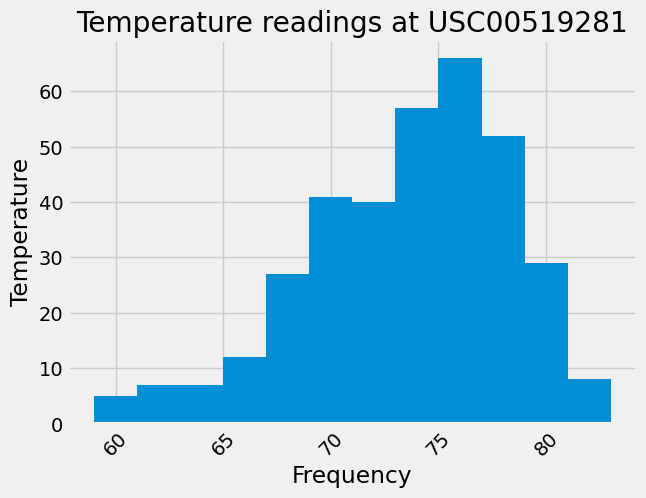

In [59]:
# Using the most active station id
# Query the last 12 months of temperature observation data for this station and plot the results as a histogram
sel = [Measurement.station,
       Measurement.tobs]
station_temps = session.query(*sel).\
    filter(Measurement.station == most_active, func.strftime(Measurement.date) >= year_prior).\
    group_by(Measurement.date).\
    order_by(Measurement.date).all()
station_temps_df = pd.DataFrame(station_temps, columns = ['Measurement_date', 'Temperature'])
station_temps_df.set_index('Measurement_date', inplace = True)

plt.hist(station_temps_df['Temperature'],bins=12)
plt.title(f'Temperature readings at {most_active}')
plt.tight_layout()
plt.xlabel('Frequency')
plt.ylabel('Temperature')
plt.xticks(rotation = 45)
plt.show()


# Close Session

In [60]:
# Close Session
session.close()